<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFEedgesNumbaDask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd /content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE
! git pull

/content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE
Already up to date.


importing 
---



In [0]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

CPU times: user 258 ms, sys: 79 ms, total: 337 ms
Wall time: 1min 31s


In [0]:
%%time
import datetime
import glob
from math import sqrt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 859 ms, sys: 158 ms, total: 1.02 s
Wall time: 2.39 s


In [0]:
# %%capture
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/139/13,Cluster Workers: 1 Cores: 4 Memory: 27.39 GB


runs
---



In [0]:
path = './data'
pathShapefile = './data/shapefile'
path_output = '../../02_output'

**Load GIS data**



---






In [0]:
def load_data(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(pathShapefile, file_name), bbox=bbox)
    gdf_buildings['X'] = gdf_buildings.geometry.centroid.x
    gdf_buildings['Y'] = gdf_buildings.geometry.centroid.y

    # print(gdf_buildings.dtypes)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    # print("Data size:{} GB'".format(data_size))
    # gdf_buildings.IgnProb_bl = 0.02
    # xmin,ymin,xmax,ymax = gdf_buildings.total_bounds

    # # Precision of float32 is sufficient for lat and lon
    # float_columns = ['SHAPE_Leng','SHAPE_Area',
    #                 'IgnProb_bl','RandProb']
    # gdf_buildings[float_columns] = gdf_buildings[float_columns].astype('float32')
    # int_columns = ['TARGET_FID','Combustibl',
    #                 'AU2013Num','RandProb']
    # gdf_buildings[int_columns] = gdf_buildings[int_columns].astype('int32')
    # data_size = getsizeof(gdf_buildings)/(1024.0**3)
    # print("resized Data size:{} GB'".format(data_size))

    return gdf_buildings


def clean_up_file(prefix, path_path):
    files = glob.glob(os.path.join(path_path, prefix))
    for file in files:
        print(file)
        os.remove(file)

In [0]:
# clean_up_file("*", path_split)

Shapefile extent : [1748498.0152998  5425264.79535007 1749563.95249987 5427653.74945021]
Asset loaded : 1611
CPU times: user 1.54 s, sys: 395 ms, total: 1.93 s
Wall time: 3.09 s


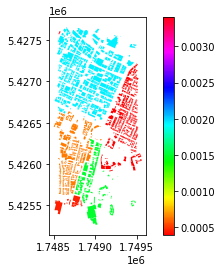

In [0]:
%%time
# load data
gdf = load_data("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
# gdf = load_data("buildings_raw.shp", 1745000, 5424148, 1750000, 5430000) # larger
# gdf = load_data("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole
gdf.plot(column='IgnProb_bl', cmap='hsv', legend=True)

**List of Functions**



---





In [0]:
%%time
# create edge list from id
fid = gdf.TARGET_FID.values
x = gdf.X.values
y = gdf.Y.values

@jit(nopython=True)
def square(x):
    return x ** 2

@jit(nopython=True)
def distance(x, y):
    return np.sqrt(square(x) + square(y))

@jit(nopython=True)
def bearing(x, y):
    azimuth = np.degrees(np.arctan2(x, y))
    return (azimuth + 360) % 360

@jit(nopython=True)
def edge_list(fid, x, y):
  list_s = []
  list_t = []
  list_distance = []
  list_bearing = []
  for idx_s, s in enumerate(fid):
    for idx_t, t in enumerate(fid):

      Vx = (x[idx_s] - x[idx_t])
      Vy = (y[idx_s] - y[idx_t])

      dist = distance(Vx, Vy)
      bear = bearing(Vx, Vy)

      if dist < 100 and dist != 0:
        
        list_s.append(s)
        list_t.append(t)
        list_distance.append(dist)
        list_bearing.append(bear)

  return list_s, list_t, list_distance, list_bearing

CPU times: user 711 µs, sys: 6 µs, total: 717 µs
Wall time: 724 µs


In [0]:
def to_dask_df(source, target, distance, bearing):
  list_of_lists = [source, target, distance, bearing]
  list_of_arrays = []
  for l in list_of_lists:
    a = da.array(l)
    list_of_arrays.append(a)

  # generate dask dataframe
  ddf = dd.concat([dd.from_dask_array(c) for c in list_of_arrays], axis = 1) 
  # name columns
  ddf.columns = ['source', 'target', 'distance', 'bearing'] # [str(c) for c in list_of_list] 

  return ddf

In [0]:
def prepare_data(ddf, gdf):
    gdf_short = gdf[['TARGET_FID', 'geometry', 'IgnProb_bl']]
    df_short = pd.DataFrame(gdf_short)
    # ddf = dd.read_parquet(os.path.join(path_output, 'dask_edge_list', file_name), engine='pyarrow')
    ddf = ddf.compute()

    # merge column of interest (geometries and Ignition probability)
    df_source = ddf.merge(df_short, how='left', left_on='source', right_on='TARGET_FID')
    gdf_short = gdf[['TARGET_FID', 'geometry']]
    # df_short = pd.DataFrame(gdf_short)
    df_target = ddf.merge(df_short, how='left', left_on='target', right_on='TARGET_FID')

    # reverse to geopandas

    gdf_source = gpd.GeoDataFrame(df_source, geometry='geometry')
    gdf_target = gpd.GeoDataFrame(df_target, geometry='geometry')

    # calculate distance polygons
    distance_series = gdf_source.distance(gdf_target)
    ddf['distance'] = distance_series
    ddf['IgnProb_bl'] = df_source.IgnProb_bl

    return ddf

In [0]:
def write_to_parquet(daskDF):
  # ddf = daskDF.compute()
  daskDF.to_parquet(os.path.join(path_output, 'smallShapeEdges.parquet'), engine='pyarrow')
  return

In [0]:
# display network
def display_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
               'with_labels': False, 'font_weight': 'bold'}
    nx.draw_kamada_kawai(graph, **options)
    plt.show()
    return graph

**Create edge list from polygon shapefile**


---




In [0]:
%%time
source, target, distance, bearing = edge_list(fid, x, y)

CPU times: user 861 ms, sys: 39.1 ms, total: 900 ms
Wall time: 905 ms


In [0]:
%%time
# create an edge list from dask dataframe
ddf = to_dask_df(source, target, distance, bearing)

CPU times: user 68.7 ms, sys: 4.73 ms, total: 73.4 ms
Wall time: 73.6 ms


In [0]:
%%time
# add geometries and distance between polygons
ddf = prepare_data(ddf, gdf)

CPU times: user 3.34 s, sys: 87.9 ms, total: 3.43 s
Wall time: 3.3 s


In [0]:
# export to parquet (would need deleting previous parquet)
write_to_parquet(daskDF=ddf)

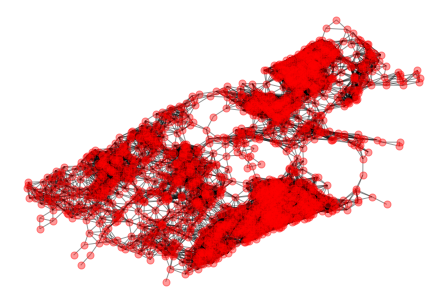

In [0]:
# # display network
G = display_network(ddf)